# Adversarial Search

Until now, we have considered only environments with one agent. In this part, we consider competitive environment, in which agents goals are in conflict. So the search problem are called adversarial search problem or games. In particular, we consider deterministic, turn-taking, 2 player, zero-sum games of perfect information. Which means deterministic, fully observable environments, in which the utility values of the agents are equal and opposite.

## Game Implementation

We can view a game as as a kind of research problem, with this elements:

- Initial state
- Terminal state

Methods

- player(state)
- successors(state)
- actions(state)
- result(state, action)
- terminal_test(state)
- utility(state, player)

As with classical search, the initial state and the successors define a game tree, where nodes are game states and edges are moves.

In [14]:
class Game:
    def __init__(self, initial_state, terminal_state=None):
        self.initial_state = initial_state
        self.terminal_state = terminal_state
        self.player = 'MAX'
        
    def successors(self, state):
        actions = self.actions(state)
        return [(self.result(state, action), action) for action in actions]
        
    def actions(self, state):
        pass
    
    def result(self, state, action):
        pass
    
    def terminal_test(self, state):
        pass
    
    def utility(self, state):
        pass
    
    def next_player(self):
        pass

## Dummy Game

In particular, to demonstrate the algorithms for adversarial search we will use the dummy game sample.


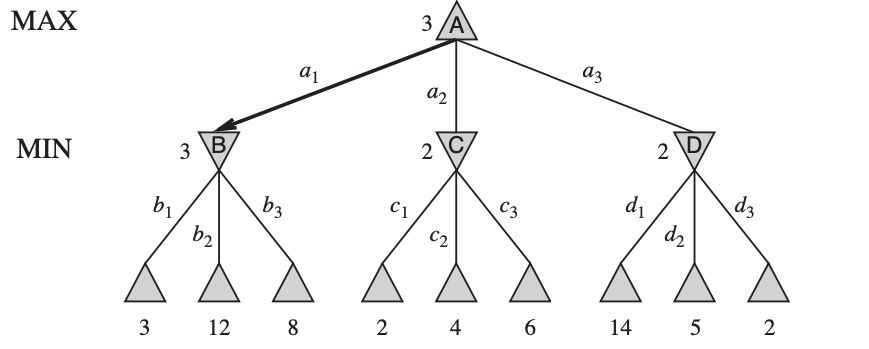

In [15]:
from IPython.display import Image
Image(filename='images/dummy_game.png') 

In [16]:
class DummyGame:
    def __init__(self, initial_state, terminal_state, environment, player='MAX'):
        self.initial_state = initial_state
        self.player = player
        self.environment = environment
        self.terminal_state = terminal_state

    def successors(self, state):
        actions = self.actions(state)
        return [(self.result(state, action), action) for action in actions]

    def actions(self, state):
        return self.environment[state].keys()

    def result(self, state, action):
        return self.environment[state][action]

    def terminal_test(self, state):
        return state in self.terminal_state.keys()

    def next_player(self):
        if self.player == 'MAX':
            self.player = 'MIN'
        else:
            self.player = 'MAX'

    def utility(self, state):
        if self.player == 'MAX':
            return self.terminal_state[state]
        else:
            return - self.terminal_state[state]
        

we will initialize it with the configuration in the image:

In [17]:
dummy_environment = {
    'A': {'a1': 'B', 'a2': 'C', 'a3': 'D'},
    'B': {'b1': 'E', 'b2': 'F', 'b3': 'G'},
    'C': {'c1': 'H', 'c2': 'I', 'c3': 'L'},
    'D': {'d1': 'M', 'd2': 'N', 'd3': 'O'},
}

terminal_state = {
    'E': 3,
    'F': 12,
    'G': 8,
    'H': 2,
    'I': 4,
    'L': 6,
    'M': 14,
    'N': 5,
    'O': 2
}


game = DummyGame(initial_state='A', environment=dummy_environment, terminal_state=terminal_state)
print(game.result('A', 'a1'))
print(game.actions('A'))
print(game.successors('A'))
print(game.utility('O'))
print(game.terminal_test('O'))
print(game.terminal_test('A'))

B
dict_keys(['a1', 'a2', 'a3'])
[('B', 'a1'), ('C', 'a2'), ('D', 'a3')]
2
True
False


## Minimax

The minimax algorithm provides a fundamental strategy for decision-making in adversarial games. 

It recursively computes the optimal move by evaluating the minimax value of each possible successor state, assuming both players act optimally. 

Starting from the leaves of the game tree, minimax values are propagated back up to determine the best move for the current player. 

This ensures that MAX maximizes its minimum guaranteed outcome, considering that MIN will always try to minimize MAX’s advantage.

The minimax value of a state `s` is defined as:

\begin{cases}
\text{MINIMAX}(s) = \text{UTILITY}(s) & \text{if TERMINAL-TEST}(s) \\
\max\limits_{a \in \text{Actions}(s)} \text{MINIMAX}(\text{RESULT}(s, a)) & \text{if PLAYER}(s) = \text{MAX} \\
\min\limits_{a \in \text{Actions}(s)} \text{MINIMAX}(\text{RESULT}(s, a)) & \text{if PLAYER}(s) = \text{MIN}
\end{cases}


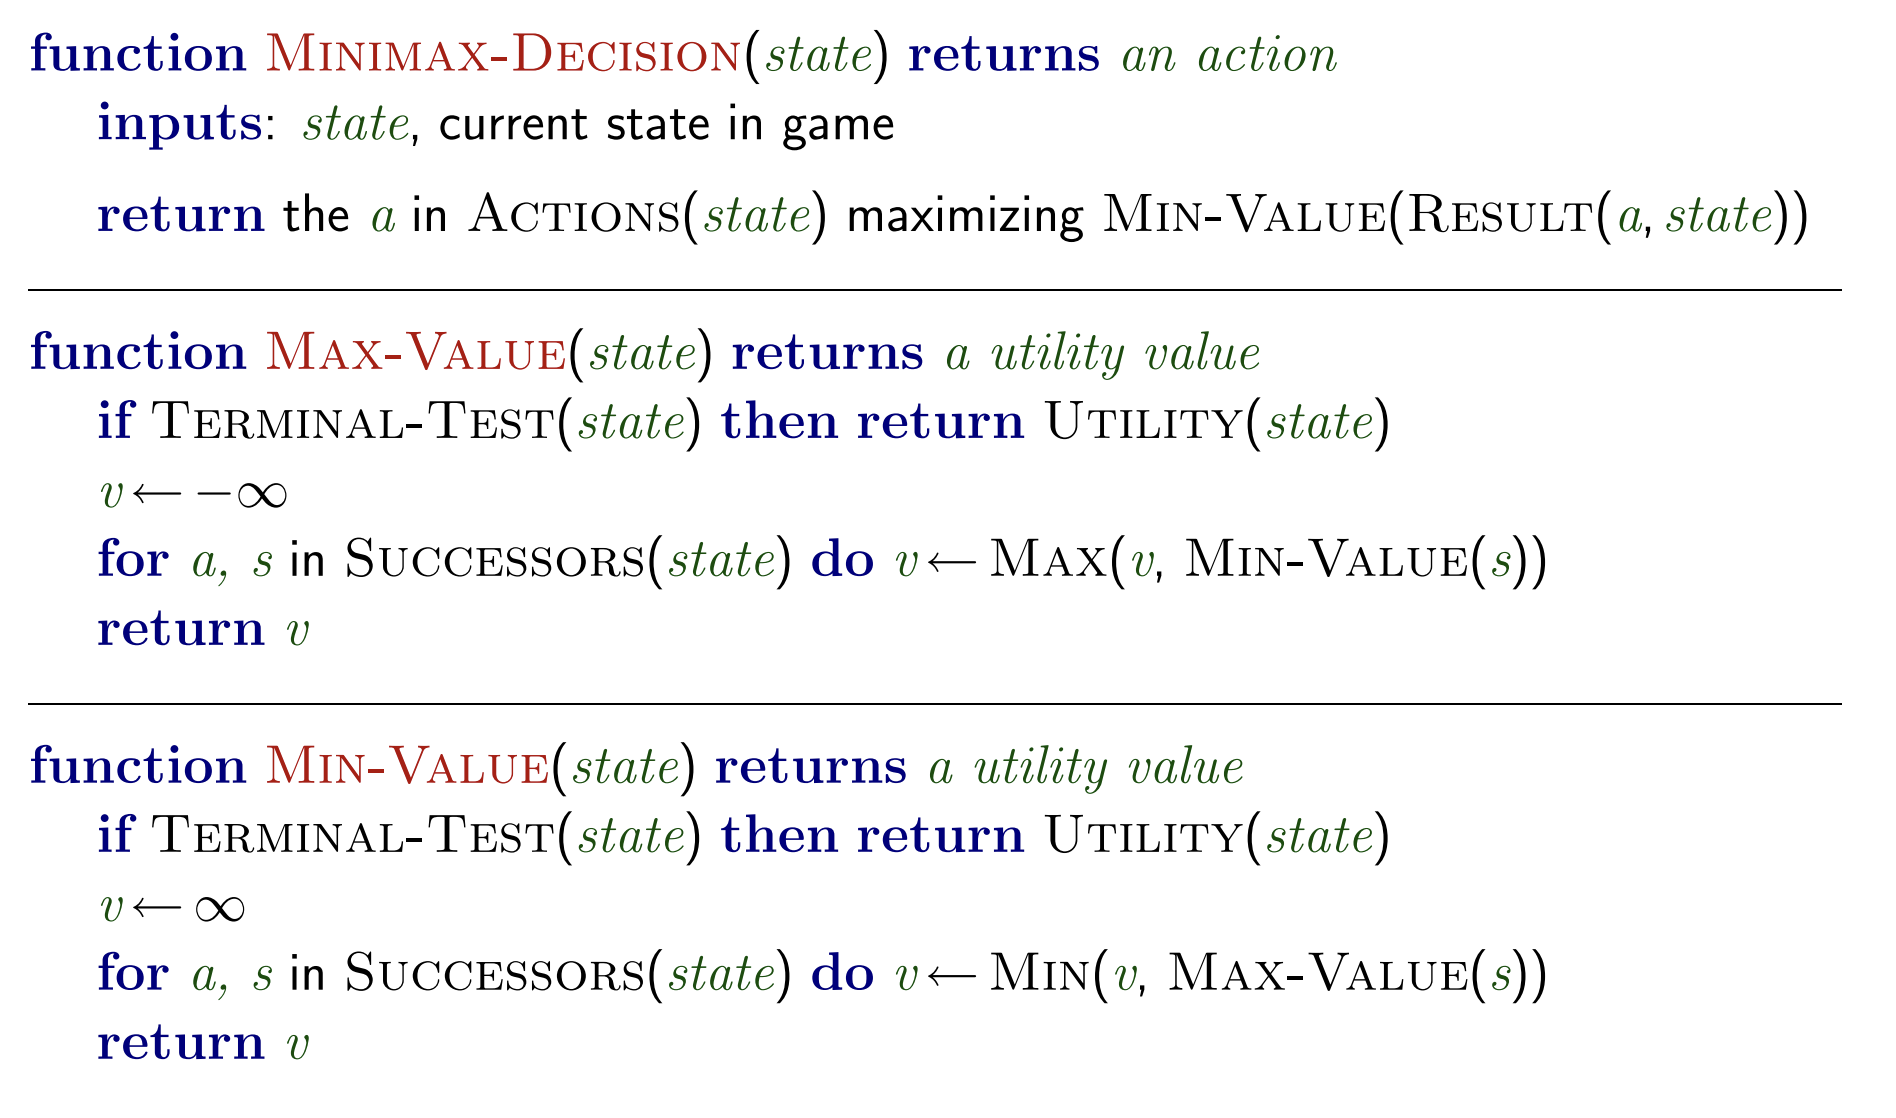

In [18]:
from IPython.display import Image
Image(filename='images/minmax.png') 

In [19]:
import numpy as np

class MiniMax:
    def __init__(self, game):
        self.game = game

    def minimax_decision(self, state):
        return max(self.game.actions(state), key=lambda action: self.min_value(game.result(state, action)))

    def max_value(self, state):
        if self.game.terminal_test(state):
            return self.game.utility(state)

        value = - np.inf
        for state, action in self.game.successors(state):
            value = max(value, self.min_value(state))

        return value

    def min_value(self, state):
        if self.game.terminal_test(state):
            return self.game.utility(state)

        value = np.inf
        for state, action in self.game.successors(state):
            value = min(value, self.max_value(state))

        return value

    def run(self):
        moves = []
        state = self.game.initial_state

        while True:
            if self.game.terminal_test(state):
                return moves

            action = self.minimax_decision(state)
            state = self.game.result(state, action)
            moves.append((self.game.player, action))
            self.game.next_player()
    

we can find a solution:

In [20]:
search = MiniMax(game)
print(search.run())

[('MAX', 'a1'), ('MIN', 'b1')]


## Alpha-Beta Pruning

Alpha–beta pruning is an optimization technique for the minimax algorithm that allows large parts of the search tree to be ignored without affecting the final decision. 

By keeping track of the best options found so far for both players, α for MAX and β for MIN, the algorithm can prune branches that cannot possibly influence the outcome. 

Since minimax performs depth-first search, alpha–beta pruning efficiently updates α and β values during traversal, significantly reducing the number of nodes evaluated.

At any point during search:

- $\alpha$ = the best (highest) value found so far along the path for MAX.
- $\beta$ = the best (lowest) value found so far along the path for MIN.

Pruning occurs when:

- For a MAX node: if the current value $\geq \beta$
- For a MIN node: if the current value $\leq \alpha$

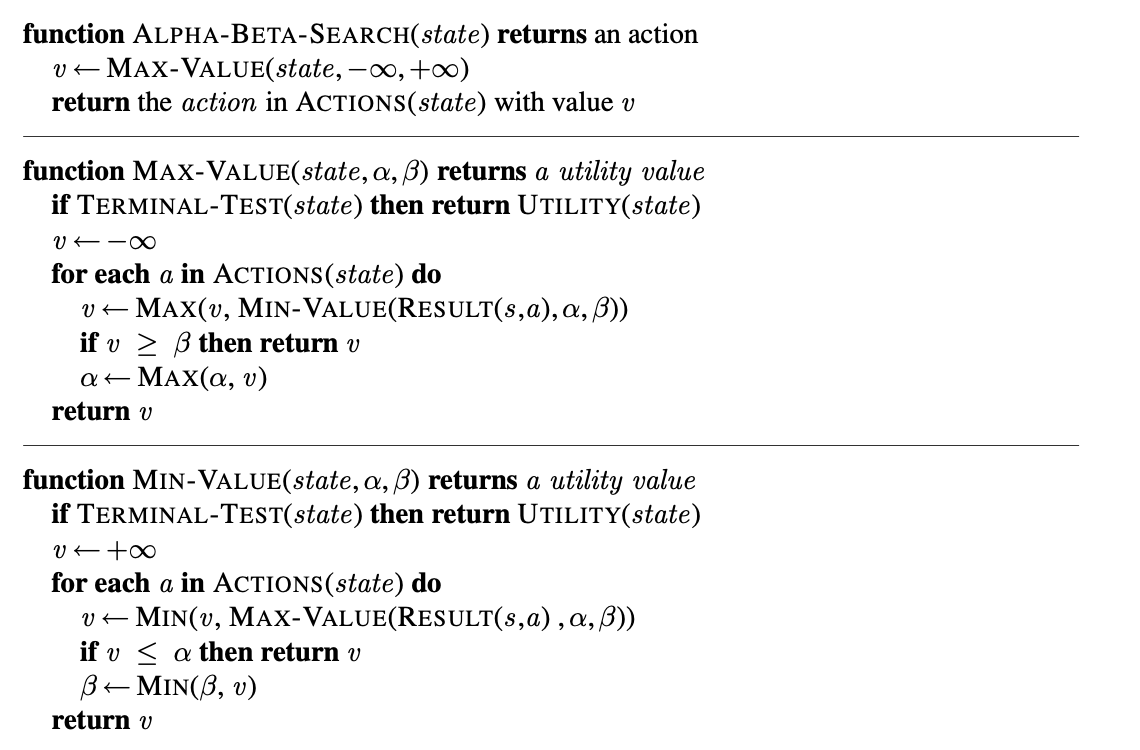

In [21]:
from IPython.display import Image
Image(filename='images/alpha_beta.png') 

In [22]:
import numpy as np

class AlphaBeta:
    def __init__(self, game):
        self.game = game

    def alphabeta_decision(self, state):
        return max(self.game.actions(state), key=lambda action: self.min_value(game.result(state, action), -np.inf, np.inf))

    def max_value(self, state, alpha, beta):
        if self.game.terminal_test(state):
            return self.game.utility(state)

        value = - np.inf
        for state, action in self.game.successors(state):
            value = max(value, self.min_value(state, alpha, beta))
            
            if value >= beta:
                return value
            
            alpha = max(alpha, value)
            
        return value

    def min_value(self, state, alpha, beta):
        if self.game.terminal_test(state):
            return self.game.utility(state)

        value = np.inf
        for state, action in self.game.successors(state):
            value = min(value, self.max_value(state, alpha, beta))
            
            if value <= alpha:
                return value
            
            beta = min(beta, value)

        return value

    def run(self):
        moves = []
        state = self.game.initial_state

        while True:
            if self.game.terminal_test(state):
                return moves

            action = self.alphabeta_decision(state)
            state = self.game.result(state, action)
            moves.append((self.game.player, action))
            self.game.next_player()

we can find a solution:

In [23]:
search = AlphaBeta(game)
print(search.run())

[('MAX', 'a1'), ('MIN', 'b1')]


## Tic Tac Toe

We will se the tictactoe game as an implicit implementation of a game.

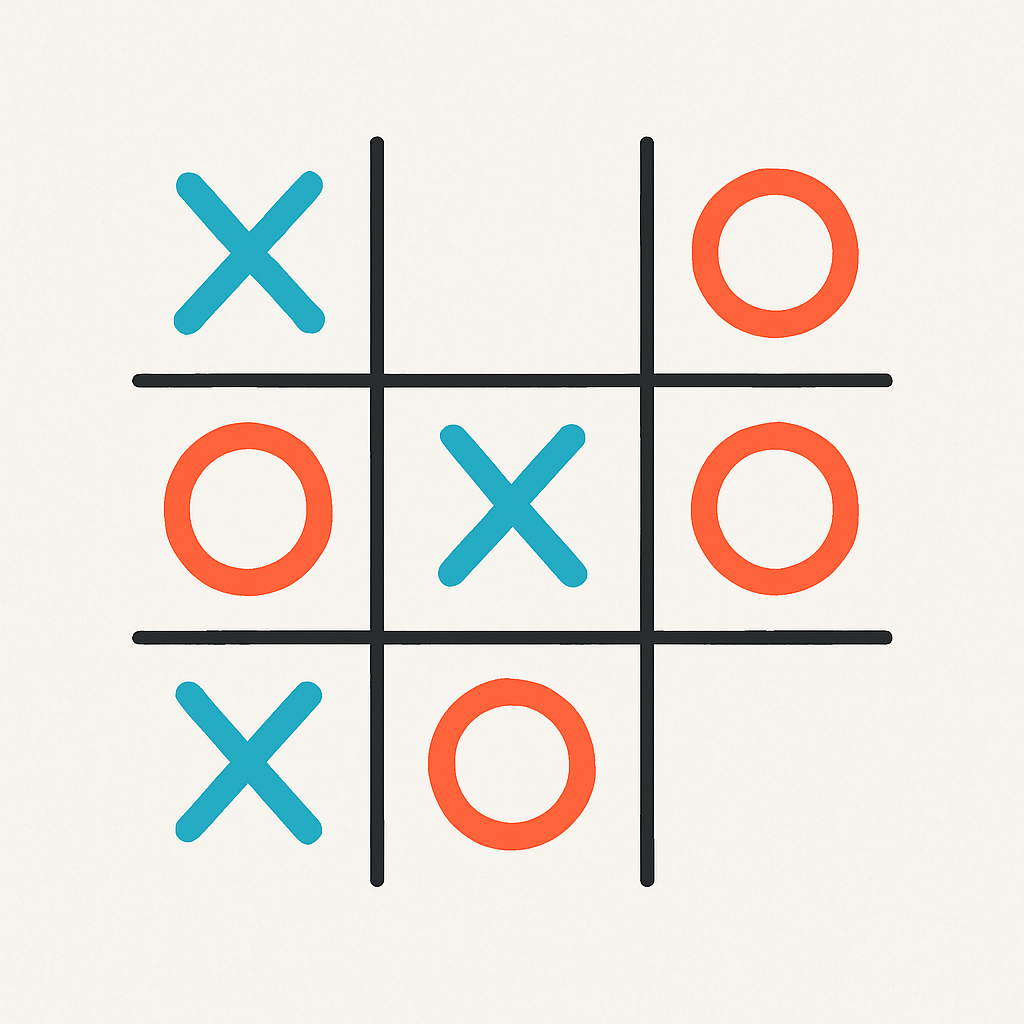

In [31]:
from IPython.display import Image
Image(filename='images/tictactoe.png')

In [25]:
class TicTacToeGame:
    def __init__(self, size=3):
        self.size = size
        self.initial_state = [' '] * (size * size)
        self.player = 'X'
        
    def successors(self, state):
        actions = self.actions(state)
        return [(self.result(state, action), action) for action in actions]

    def actions(self, state):
        return [i for i, cell in enumerate(state) if cell == ' ']

    def result(self, state, action):
        new_state = state.copy()
        new_state[action] = self.player
        return new_state

    def terminal_test(self, state):
        return self.check_winner(state) is not None or ' ' not in state

    def utility(self, state):
        winner = self.check_winner(state)
        if winner == 'X':
            return 1
        elif winner == 'O':
            return -1
        else:
            return 0

    def next_player(self):
        self.player = 'O' if self.player == 'X' else 'X'

    def check_winner(self, state):
        for i in range(0, len(state), self.size):
            row = state[i:i + self.size]
            if ' ' not in row and len(set(row)) == 1:
                return row[0]

        for col in range(self.size):
            column = [state[row * self.size + col] for row in range(self.size)]
            if ' ' not in column and len(set(column)) == 1:
                return column[0]

        main_diag = state[0 : self.size**2 : self.size + 1]
        if ' ' not in main_diag and len(set(main_diag)) == 1:
            return main_diag[0]
        
        anti_diag = state[self.size - 1 : self.size**2 - 1 : self.size - 1]
        if ' ' not in anti_diag and len(set(anti_diag)) == 1:
            return anti_diag[0]

        return None


we can try our implementation:

In [26]:
game = TicTacToeGame(size=3)
print(game.actions(game.initial_state))
state = game.result(game.initial_state, 0)
print(state)
print(game.terminal_test(['X', 'X', 'X', ' ', ' ', ' ', ' ', ' ', ' ']))


[0, 1, 2, 3, 4, 5, 6, 7, 8]
['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
True


and use minimax and alpha-beta pruning to solve it:

In [27]:
search = AlphaBeta(game)
print(search.run())
search = MiniMax(game)
print(search.run())

[('X', 0), ('O', 1), ('X', 2), ('O', 3), ('X', 4), ('O', 5), ('X', 6)]
[('O', 0), ('X', 1), ('O', 2), ('X', 3), ('O', 4), ('X', 5), ('O', 6)]
